In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from numpy.linalg import inv

Function

In [4]:
def calc_portfolio_return(e, w):
    """return the portfolio return for a portfolio of n>=2 assets.
    e: a matrix of expected returns for the assets
    w: a matrix of portfolio weights of the assets
    """
    return float(e * w.T)

In [5]:
def calc_portfolio_stdev(v, w):
    """return the portfolio standard deviation for a portfolio of n>= 2 assets.
    v: a matrix of covariances among the assets
    """
    return float(w * v * w.T)**0.5

In [6]:
# get daily prices
def get_stock_prices_from_csv_files(symbols):
    """return pands.DataFrame object containing historical stock prices for
    several stocks.
    """
    prices = pd.DataFrame()
    fn = '/content/drive/MyDrive/5010_Project/%s.csv' % symbols[0]
    df = pd.read_csv(fn)
    prices.index = df['Date']
    for symbol in symbols:
        fn = '/content/drive/MyDrive/5010_Project/%s.csv' % symbol
        df = pd.read_csv(fn)
        df.index = df['Date']
        prices[symbol] = df['Adj Close']
    return prices


In [7]:
# get daily return
def get_stock_returns_from_csv_files(symbols):
    """return pandas.DataFrame object containing stock returns"""
    prices = get_stock_prices_from_csv_files(symbols)
    return prices/prices.shift(1) - 1

In [8]:
# get v
def get_covariance_matrix(returns):
    """get a covariance matrix for the stock returns"""
    return returns.cov()

In [9]:
# efficient frontier weights
def calc_global_min_variance_portfolio(v):
    """return the portfolio weights corresponding to the global minimum
    variance portfolio."""
    ctemp = np.ones(len(v)) * inv(v) * np.matrix(np.ones(len(v))).T
    sigma_min = 1 / ctemp
    return sigma_min * np.ones(len(v)) * inv(v)


In [10]:
from scipy.stats import norm
# VaR
def compute_historical_var_pct(returns, x, n):
    """using historical simulation approach to return the value at risk"""
    returns.sort_values(ascending = True)
    var = returns.iloc[int((1- x) * len(returns)) - 1]
    day_var = var * n**0.5
    return day_var


In [11]:
# drawdown
def compute_drawdown(prices):
    """return dataframe that shows price, prev_max: peak price,
    dd_dollars: drawdown, dd_pct: percentage decline since peak price
    """
    df = pd.DataFrame(index = prices.index)
    prev_max = pd.Series(index = prices.index)
    df['price'] = prices
    #loop to find the previous maximum price
    max_price = df['price'].iloc[0]
    for i in range(len(df)):
        if df['price'].iloc[i] > max_price:
            max_price = df['price'].iloc[i]
        prev_max[i] = max_price
    df['prev_max'] = prev_max
    df['dd_dollars'] = df['prev_max'] - df['price']
    df['dd_pct'] = df['dd_dollars'] / df['prev_max']
    return df

def plot_drawdown(df):
    """draw two charts that contains the historical and maximum prices, and
    the drawdown since previous maximum price
    """
    df[['price', 'prev_max']].plot(title = 'Price and Previous Maximum')
    df[['dd_pct']].plot(title = 'Drawdown Percentage')


In [12]:
#rebalancing
def plot_relative_weights_over_time(df_values):
    """create a plot showing the weights of each asset"""
    for i in range(len(df_values.columns)-1):
        df_values.iloc[:, i].plot()

def rebalance_portfolio(df_prices, target_weights, rebalance_freq,
                        initial_value = 1):
    """return a dataframe with columns containing the values in each asset
    according to the target weights with rebalancing frequency
    """
    df = df_prices/ df_prices.shift(1) - 1
    df2 = pd.DataFrame(index = df_prices.index, columns = df_prices.columns)
    no_columns = len(df_prices.columns)
    #loop to change the price to weight
    df2['portfolio'] = df.sum(axis = 1)
    df2['portfolio'].iloc[0] = initial_value
    #loop to set the first row
    for i in range(no_columns):
        the_weight = target_weights[df2.columns[i]]
        df2.iloc[0, i] = initial_value * the_weight

    #loop to run the rest rows
    for j in range(1, len(df_prices)):
        # calculate the weight using returns
        if j != j // rebalance_freq * rebalance_freq:
            for i in range(no_columns):
                df2.iloc[j, i] = df2.iloc[j-1, i] * (1 + df.iloc[j, i])
            df2['portfolio'].iloc[j] = df2.iloc[j, :-1].sum()
        else: # the row that need rebalancing
            row_sum = 0
            for i in range(no_columns):
                row_sum += df2.iloc[j-1, i] * (1 + df.iloc[j, i])
            df2['portfolio'].iloc[j] = row_sum
            for i in range(no_columns):
                df2.iloc[j, i] = target_weights[df2.columns[i]] * \
                    df2['portfolio'].iloc[j]
    return df2


In [13]:
def create_portfolio(df_prices, w, initial_value = 10000):
    """return a dataframe containing the values of investment in each of the
    assets and the value of the total portfolio
    """
    number_columns = len(df_prices.columns)
    df = df_prices.copy()
    returns = df_prices/df_prices.iloc[0] -1
    print(df)

    for i in range(number_columns):
        if i ==0:
            df.iloc[:, i] = initial_value* w[0,i]
        df.iloc[:, i] = initial_value* w[0,i]*(1+returns.iloc[:,i])
    df['portfolio'] = df.sum(axis = 1)
    return df

In [14]:
def comparing_portfolios(symbols):
    """compare the risk and return of investing in an equal-weighted portfolio
    and a mean-variance efficient portfolio
    """
    the_price = get_stock_prices_from_csv_files(symbols)
    target_weight= {}
    for s in symbols:
        target_weight[s] = 1 / len(symbols)

    # without rebalancing, compare the equally-weighted and min variance
    # efficient portfolio
    eq_wo_reb = create_equal_weight_portfolio(the_price)
    ret_eq_wo_reb = eq_wo_reb / eq_wo_reb.shift(1) - 1
    print(ret_eq_wo_reb.describe())

    the_variance = np.matrix(get_covariance_matrix(ret_eq_wo_reb))
    final_ret = np.matrix(ret_eq_wo_reb.mean())

    min_var_wo_reb = calc_global_min_variance_portfolio(the_variance)

    ret_min_var_wo_reb = calc_portfolio_return(final_ret, min_var_wo_reb)
    stdev_min_var_wo_reb = calc_portfolio_stdev(the_variance, min_var_wo_reb)
    print('The mean return for min variance portfolio: ',
          f'{ret_min_var_wo_reb:.6f}')
    print('The standard deviation of the reutrn for min variance portfolio: '+\
          f'{stdev_min_var_wo_reb:.6f}')
    # without rebalancing in 20 days, compare the equally-weighted and min variance
    # efficient portfolio
    eq_with_reb_20 = rebalance_portfolio(the_price, target_weight, 20)
    ret_eq_with_reb_20 = eq_with_reb_20 / eq_with_reb_20.shift(1) - 1
    print(ret_eq_with_reb_20.describe())

    the_variance_20 = np.matrix(get_covariance_matrix(ret_eq_with_reb_20))
    final_ret_20 = np.matrix(ret_eq_with_reb_20.mean())




Test Case:

In [15]:
symbols = ['AAPL',  'BAC',  'MC.PA', 'KO', 'TSLA']
price = get_stock_prices_from_csv_files(symbols)
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 2021-04-26 to 2023-04-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    503 non-null    float64
 1   BAC     503 non-null    float64
 2   MC.PA   501 non-null    float64
 3   KO      503 non-null    float64
 4   TSLA    503 non-null    float64
dtypes: float64(5)
memory usage: 23.6+ KB


In [16]:
price = price.fillna(price.bfill())
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 2021-04-26 to 2023-04-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    503 non-null    float64
 1   BAC     503 non-null    float64
 2   MC.PA   503 non-null    float64
 3   KO      503 non-null    float64
 4   TSLA    503 non-null    float64
dtypes: float64(5)
memory usage: 23.6+ KB


In [17]:
returns = get_stock_returns_from_csv_files(symbols)
returns

,AAPL,BAC,MC.PA,KO,TSLA
Date,,,,,
2021-04-26,NaN,NaN,NaN,NaN,NaN
2021-04-27,-0.002450,0.011926,0.011026,-0.001491,-0.045326
2021-04-28,-0.006027,0.003761,0.000790,0.000187,-0.014672
2021-04-29,-0.000749,0.026980,0.003948,0.012502,-0.025058
2021-04-30,-0.015133,-0.014109,-0.014944,-0.005160,0.047917
...,...,...,...,...,...
2023-04-18,0.007505,0.006256,0.004464,0.001576,-0.014596
2023-04-19,0.006968,-0.016361,0.008547,0.001888,-0.020183
2023-04-20,-0.005846,-0.005323,0.012994,0.004397,-0.097458


In [18]:
v = np.matrix(get_covariance_matrix(returns))
v

matrix([[3.53179167e-04, 1.52094525e-04, 1.47881920e-04, 8.89461671e-05,
         3.97070286e-04],
        [1.52094525e-04, 3.39336181e-04, 1.34557362e-04, 7.11009192e-05,
         2.35820342e-04],
        [1.47881920e-04, 1.34557362e-04, 3.49086376e-04, 5.59785986e-05,
         1.92722270e-04],
        [8.89461671e-05, 7.11009192e-05, 5.59785986e-05, 1.12726283e-04,
         5.65364307e-05],
        [3.97070286e-04, 2.35820342e-04, 1.92722270e-04, 5.65364307e-05,
         1.46248762e-03]])

In [19]:
w = calc_global_min_variance_portfolio(v)
w

matrix([[-0.01598014,  0.078828  ,  0.1332812 ,  0.79095605,  0.01291489]])

In [20]:
df_exp_return = pd.DataFrame(returns)
df_exp_return

,AAPL,BAC,MC.PA,KO,TSLA
Date,,,,,
2021-04-26,NaN,NaN,NaN,NaN,NaN
2021-04-27,-0.002450,0.011926,0.011026,-0.001491,-0.045326
2021-04-28,-0.006027,0.003761,0.000790,0.000187,-0.014672
2021-04-29,-0.000749,0.026980,0.003948,0.012502,-0.025058
2021-04-30,-0.015133,-0.014109,-0.014944,-0.005160,0.047917
...,...,...,...,...,...
2023-04-18,0.007505,0.006256,0.004464,0.001576,-0.014596
2023-04-19,0.006968,-0.016361,0.008547,0.001888,-0.020183
2023-04-20,-0.005846,-0.005323,0.012994,0.004397,-0.097458


In [21]:
portfolio_price = create_portfolio(price,w)
portfolio_price

                  AAPL        BAC       MC.PA         KO        TSLA
Date                                                                
2021-04-26  133.117661  37.728798  607.096069  50.557941  246.066666
2021-04-27  132.791565  38.178757  613.789856  50.482563  234.913330
2021-04-28  131.991211  38.322353  614.274902  50.491982  231.466660
2021-04-29  131.892365  39.356285  616.700195  51.123253  225.666672
2021-04-30  129.896408  38.801025  607.484070  50.859444  236.479996
...                ...        ...         ...        ...         ...
2023-04-18  166.470001  30.559999  870.690125  63.560001  184.309998
2023-04-19  167.630005  30.059999  878.131958  63.680000  180.589996
2023-04-20  166.649994  29.900000  889.542664  63.959999  162.990005
2023-04-21  165.020004  29.870001  894.106995  64.050003  165.080002
2023-04-24  165.330002  29.760000  895.000000  63.950001  162.550003

[503 rows x 5 columns]


,AAPL,BAC,MC.PA,KO,TSLA,portfolio
Date,,,,,,
2021-04-26,-159.801378,788.279992,1332.812002,7909.560474,129.148910,10000.000000
2021-04-27,-159.409915,797.681131,1347.507468,7897.767928,123.295045,10006.841656
2021-04-28,-158.449129,800.681329,1348.572333,7899.241487,121.486049,10011.532069
2021-04-29,-158.330469,822.283605,1353.896794,7998.000971,118.441906,10134.292807
2021-04-30,-155.934418,810.682378,1333.663815,7956.729250,124.117315,10069.258340
...,...,...,...,...,...,...
2023-04-18,-199.839265,638.499953,1911.503480,9943.673767,96.735717,12390.573652
2023-04-19,-201.231794,628.053291,1927.841198,9962.447066,94.783262,12411.893023
2023-04-20,-200.055338,624.710381,1952.892136,10006.251639,85.545848,12469.344665


In [22]:
portfolio_return = portfolio_price/portfolio_price.shift(1)-1

In [23]:
import math

print(f'The result of the portfolio without balancing:')
yearly_returns = np.array([portfolio_price.loc[f'{i}-04-25':f'{i+1}-04-24'].portfolio[-1]/
                           portfolio_price.loc[f'{i}-04-25':f'{i+1}-04-24'].portfolio[0]-1 for i in [2021,2022]])
expected_return = yearly_returns.mean()
stdev = yearly_returns.std()
rf = 0.0251
print(f'Expected return is{expected_return}')
print(f'Standard deviation is{yearly_returns.std()}')

#sharpe_ratio
sharpe_ratio_without_rebalance = (expected_return-rf)/stdev

print(f'Sharpe ratio is {sharpe_ratio_without_rebalance}')

The result of the portfolio without balancing:
Expected return is0.11818309021055329
Standard deviation is0.08493029236834027
Sharpe ratio is 1.0959939924244528


In [24]:
#var
print(f'VaR is {compute_historical_var_pct(portfolio_return.portfolio, 0.95, 30)}')
#drawdown
df_without_balancing = compute_drawdown(portfolio_price.portfolio)
print(f'Maximum drawdown is {df_without_balancing.dd_pct.max()}')

VaR is -0.009034156958212268
Maximum drawdown is 0.15928183211716945


<ipython-input-11-4a48a2b16ce7>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prev_max = pd.Series(index = prices.index)


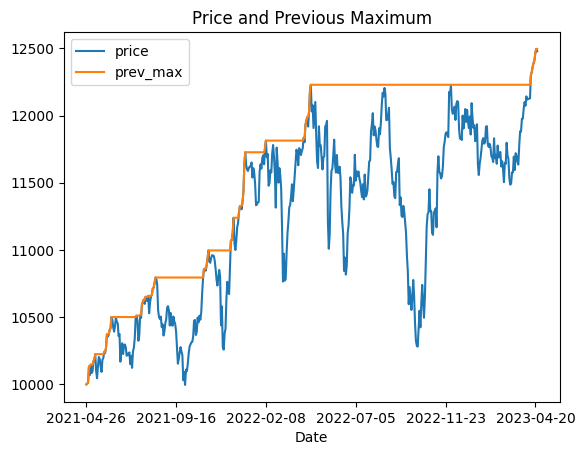

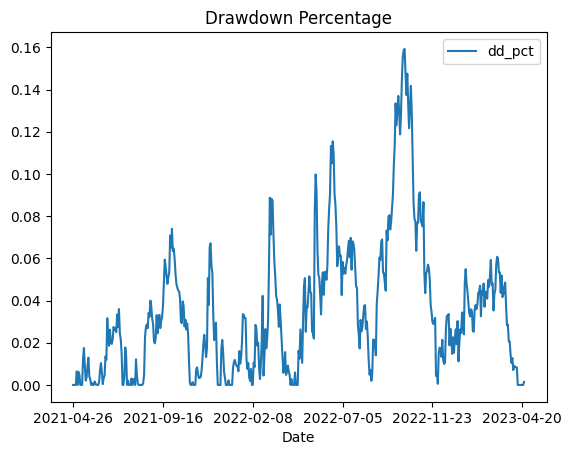

In [25]:
plot_drawdown(df_without_balancing)

In [26]:
# building portfolio with rebalancing
target_weights = {'AAPL':-0.01598014 ,  'BAC':0.078828,  'MC.PA':0.1332812, 'KO':0.79095605, 'TSLA':0.01291489}

In [27]:
portfolio_price_rebalance = rebalance_portfolio(price, target_weights, 20,
                        initial_value = 10000)
portfolio_price_rebalance

<ipython-input-12-a50890060d91>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['portfolio'].iloc[0] = initial_value
<ipython-input-12-a50890060d91>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['portfolio'].iloc[j] = df2.iloc[j, :-1].sum()
<ipython-input-12-a50890060d91>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['portfolio'].iloc[j] = row_sum


,AAPL,BAC,MC.PA,KO,TSLA,portfolio
Date,,,,,,
2021-04-26,-159.8014,788.28,1332.812,7909.5605,129.1489,10000.000000
2021-04-27,-159.409937,797.681139,1347.507466,7897.767954,123.295035,10006.841657
2021-04-28,-158.449151,800.681337,1348.572331,7899.241514,121.486039,10011.532069
2021-04-29,-158.330491,822.283613,1353.896792,7998.000998,118.441896,10134.292808
2021-04-30,-155.934439,810.682386,1333.663813,7956.729277,124.117305,10069.258341
...,...,...,...,...,...,...
2023-04-18,-198.019618,1023.945967,1686.137129,9835.681622,146.300745,12494.045844
2023-04-19,-199.399468,1007.192924,1700.548629,9854.251036,143.347898,12505.941020
2023-04-20,-200.60192,989.54378,1673.10578,9929.030794,162.123218,12553.201653


In [28]:
portfolio_return_rebalance = portfolio_price_rebalance/portfolio_price_rebalance.shift(1)-1

In [29]:
print('The result of the portfolio with rebalancing:')
yearly_returns_reb = np.array([portfolio_price_rebalance.loc[f'{i}-04-25':f'{i+1}-04-24'].portfolio[-1]/
                               portfolio_price_rebalance.loc[f'{i}-04-25':f'{i+1}-04-24'].portfolio[0]-1 for i in [2021,2022]])
expected_return_rebalance = yearly_returns_reb.mean()
stdev_rebalance = yearly_returns_reb.std()
sharpe_ratio_with_rebalance = (expected_return_rebalance-rf)/stdev_rebalance
print(f'Expect return is {expected_return_rebalance}')
print(f'Standard deviation is {stdev_rebalance}')
print(f'Sharpe ratio is {sharpe_ratio_with_rebalance}')

The result of the portfolio with rebalancing:
Expect return is 0.12206190773016523
Standard deviation is 0.08199510198778226
Sharpe ratio is 1.1825329242789784


In [30]:
print(f'VaR is {compute_historical_var_pct(portfolio_return_rebalance.portfolio, 0.95, 30)}')
df_with_balancing = compute_drawdown(portfolio_price_rebalance.portfolio)
print(f'Maximum drawdown is {df_with_balancing.dd_pct.max()}')

VaR is -0.009036953238470497
Maximum drawdown is 0.15752601470161934


<ipython-input-11-4a48a2b16ce7>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prev_max = pd.Series(index = prices.index)


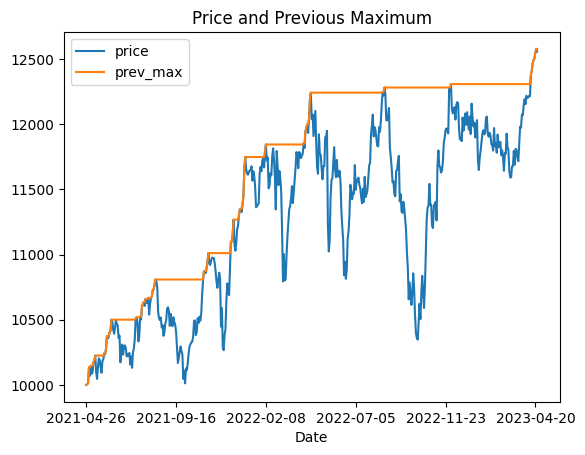

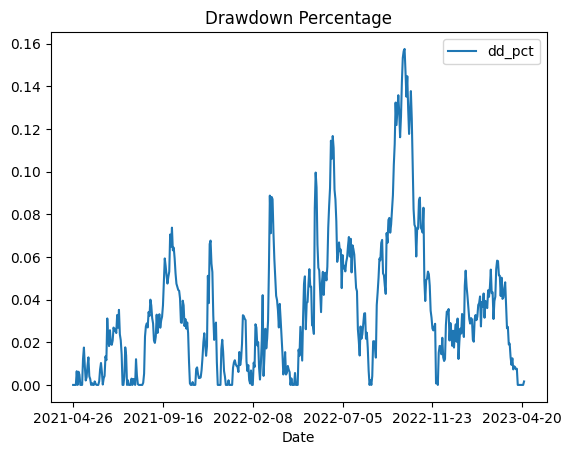

In [31]:
plot_drawdown(df_with_balancing)